In [5]:
#@ IMPORTING LIBRARIES AND DEPENDENCIES:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

%matplotlib inline

In [6]:
#@ READING DATASET:
PATH = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv"
select_cols = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", 
               "median_income", "median_house_value", "ocean_proximity"]
df = pd.read_csv(PATH, usecols=select_cols)
df.total_bedrooms = df.total_bedrooms.fillna(0)

In [12]:
df.median_house_value = np.log1p(df.median_house_value)

In [13]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)

In [14]:
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [15]:
df_train.shape, df_val.shape, df_test.shape

((12384, 10), (4128, 10), (4128, 10))

In [18]:
y_full_train = df_full_train.median_house_value.values
y_test = df_test.median_house_value.values
y_train = df_train.median_house_value.values
y_val = df_val.median_house_value.values

del df_full_train["median_house_value"]
del df_test["median_house_value"]
del df_train["median_house_value"]
del df_val["median_house_value"]


In [25]:
def make_X(df, dv = None):
    dicts = df.to_dict(orient="records")
    if not dv:
        dv = DictVectorizer(sparse=False)
        X = dv.fit_transform(dicts)
    else:
        X = dv.transform(dicts)
    return (X, dv)

In [46]:
X_train, dv = make_X(df_train)
X_val, _  = make_X(df_val, dv)

# Q1: Which feature is used for splitting the data?

In [30]:
model = DecisionTreeRegressor(max_depth=1)

In [31]:
model.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [35]:
print(export_text(model, feature_names = dv.feature_names_))

|--- ocean_proximity=INLAND <= 0.50
|   |--- value: [12.31]
|--- ocean_proximity=INLAND >  0.50
|   |--- value: [11.61]



## Answer: Ocean_proximity = INLAND

# Q2: What's the RMSE of this Random forest model on validation?

In [38]:
 model = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1) 

In [39]:
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [48]:
preds = model.predict(X_val)

In [52]:
(mean_squared_error(preds, y_val)) ** 0.5

0.2457383433183843

In [ ]:
## Answer: RMSE = 0.246

# Q3: Plateau on n_estimators

In [54]:
scores = []
for n in range(10, 200, 10):
    model = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1) 
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    rmse = mean_squared_error(preds, y_val) ** 0.5
    scores.append((n, rmse))

In [58]:
scores_df = pd.DataFrame(scores, columns=["n", "rmse"])

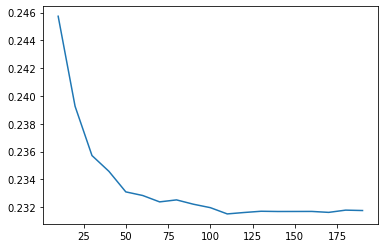

In [61]:
plt.plot(scores_df.n, scores_df.rmse)

## Answer: Performance stops improving after n = 110 

## But there is no such option, so I choose 75, as closest

# Q4 Finde best max_depth

In [62]:
scores = []
for m in [10, 15, 20, 25]:
    for n in range(10, 200, 10):
        model = RandomForestRegressor(n_estimators=n, random_state=1, max_depth=m, n_jobs=-1) 
        model.fit(X_train, y_train)
        preds = model.predict(X_val)
        rmse = mean_squared_error(preds, y_val) ** 0.5
        scores.append((n, m, rmse))

In [63]:
scores_df = pd.DataFrame(scores, columns=["n", "max_depth", "rmse"])

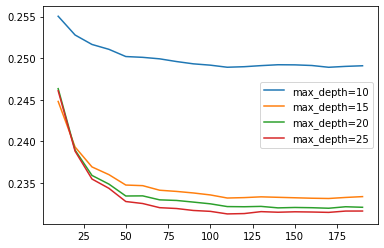

In [66]:
for m in [10, 15, 20, 25]:
    scores_subset = scores_df[scores_df.max_depth == m]
    plt.plot(scores_subset.n, scores_subset.rmse, label = f"max_depth={m}")
plt.legend()

## the best performance shows model with max_depth=25

# Q5 Best features

In [67]:
model = RandomForestRegressor(n_estimators=10, random_state=1, max_depth=20, n_jobs=-1) 
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [80]:
pd.DataFrame(( dv.feature_names_, model.feature_importances_,)).transpose().sort_values(1, ascending=False)

,0,1
4,median_income,0.362913
6,ocean_proximity=INLAND,0.310901
2,latitude,0.101334
3,longitude,0.096265
1,housing_median_age,0.033094
10,population,0.030918
12,total_rooms,0.020536
11,total_bedrooms,0.019041
0,households,0.016957
9,ocean_proximity=NEAR OCEAN,0.004228


## The most important feature is median_income

# Q6 Best eta for xgboost

In [109]:
features = dv.get_feature_names()
features = [x.replace("<","") for x in features]

In [110]:
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [111]:
watchlist= [(dtrain, "train"), (dval, "val")]

In [125]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [112]:
?xgb.XGBRegressor

In [137]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(
    xgb_params, 
    dtrain, 
    num_boost_round = 100,
    verbose_eval = 5,
    evals = watchlist
)

[0]	train-rmse:8.12733	val-rmse:8.13245
[5]	train-rmse:1.40218	val-rmse:1.40741
[10]	train-rmse:0.34481	val-rmse:0.35782
[15]	train-rmse:0.23555	val-rmse:0.26044
[20]	train-rmse:0.21580	val-rmse:0.24624
[25]	train-rmse:0.20395	val-rmse:0.24099
[30]	train-rmse:0.19440	val-rmse:0.23741
[35]	train-rmse:0.18637	val-rmse:0.23562
[40]	train-rmse:0.17983	val-rmse:0.23419
[45]	train-rmse:0.17468	val-rmse:0.23279
[50]	train-rmse:0.16934	val-rmse:0.23097
[55]	train-rmse:0.16546	val-rmse:0.23039
[60]	train-rmse:0.16177	val-rmse:0.22950
[65]	train-rmse:0.15762	val-rmse:0.22857
[70]	train-rmse:0.15323	val-rmse:0.22787
[75]	train-rmse:0.15010	val-rmse:0.22755
[80]	train-rmse:0.14564	val-rmse:0.22611
[85]	train-rmse:0.14166	val-rmse:0.22579
[90]	train-rmse:0.13892	val-rmse:0.22628
[95]	train-rmse:0.13553	val-rmse:0.22630
[99]	train-rmse:0.13299	val-rmse:0.22610


In [134]:
df_score = parse_xgb_output(output)

In [123]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

In [124]:
model = xgb.train(
    xgb_params, 
    dtrain, 
    num_boost_round = 100,
    verbose_eval = 5,
    evals = watchlist
)

[0]	train-rmse:10.44371	val-rmse:10.44938
[5]	train-rmse:6.17513	val-rmse:6.17987
[10]	train-rmse:3.65741	val-rmse:3.66135
[15]	train-rmse:2.17500	val-rmse:2.17928
[20]	train-rmse:1.30499	val-rmse:1.31054
[25]	train-rmse:0.79933	val-rmse:0.80657
[30]	train-rmse:0.51144	val-rmse:0.52189
[35]	train-rmse:0.35700	val-rmse:0.37263
[40]	train-rmse:0.27985	val-rmse:0.30053
[45]	train-rmse:0.24350	val-rmse:0.26829
[50]	train-rmse:0.22614	val-rmse:0.25334
[55]	train-rmse:0.21695	val-rmse:0.24657
[60]	train-rmse:0.21035	val-rmse:0.24189
[65]	train-rmse:0.20579	val-rmse:0.23943
[70]	train-rmse:0.20116	val-rmse:0.23684
[75]	train-rmse:0.19680	val-rmse:0.23507
[80]	train-rmse:0.19384	val-rmse:0.23398
[85]	train-rmse:0.19085	val-rmse:0.23275
[90]	train-rmse:0.18794	val-rmse:0.23206
[95]	train-rmse:0.18541	val-rmse:0.23106
[99]	train-rmse:0.18329	val-rmse:0.23054


## eta = 0.3 gives the best result val-rmse:0.22579